## Outline: <br>
II. Modelling <br>
a) [Library imports](#Library_imports)<br>
b) [Dataset imports](#Dataset_imports)<br>
c) [Functions](#Functions)<br>
d) [Modelling with resampling of minority class with SMOTE](#SMOTE)<br>
e) [Results](#Results)<br>

### Library imports
<a id="Library_imports"></a>

In [7]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
import joblib
import pickle

#Resampling
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline


#library for classification models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [8]:
pd.set_option('display.width', 5000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 500)

### Dataset imports
<a id="Dataset_imports"></a>

In [9]:
#os.chdir(r'E:\GA_DSI\Projects\Capstone\lending-club-loan-data')
os.chdir(r'D:\GA_DSI\Capstone')

In [10]:
loan_full_csv = 'loan_full_clean.csv'

with open(loan_full_csv, mode="r", encoding="utf8") as loan_full_clean_dum:
    loan_full_clean_dum = pd.read_csv(loan_full_clean_dum)

In [11]:
# Drop index feature from read
loan_full_clean_dum = loan_full_clean_dum.drop("Unnamed: 0", axis=1)

In [12]:
# Change col name to suit input variable for xgboost
loan_full_clean_dum = loan_full_clean_dum.rename(columns={"emp_length_< 1 year" : "emp_length_1 year"})

In [13]:
# Show class balance for majority / minority class
print(loan_full_clean_dum["acc_now_delinq"].value_counts(normalize=False, dropna=False))
print(loan_full_clean_dum["acc_now_delinq"].value_counts(normalize=True, dropna=False))

0.0    2251828
1.0       8782
Name: acc_now_delinq, dtype: int64
0.0    0.996115
1.0    0.003885
Name: acc_now_delinq, dtype: float64


In [14]:
# Downsampling majority using random undersampling due to memory issues
maj_class = loan_full_clean_dum[loan_full_clean_dum["acc_now_delinq"] == 0]
min_class = loan_full_clean_dum[loan_full_clean_dum["acc_now_delinq"] == 1]

In [15]:
maj_class_1 = maj_class.sample(frac=0.25, random_state=659)

In [16]:
loan_qtr_1 = maj_class_1.append(min_class)

In [17]:
loan_qtr_1 = loan_qtr_1.sample(frac=1, random_state=65).reset_index(drop=True)

In [18]:
# Show class balance for majority / minority class
print(loan_qtr_1["acc_now_delinq"].value_counts(normalize=False, dropna=False))
print(loan_qtr_1["acc_now_delinq"].value_counts(normalize=True, dropna=False))

0.0    562957
1.0      8782
Name: acc_now_delinq, dtype: int64
0.0    0.98464
1.0    0.01536
Name: acc_now_delinq, dtype: float64


In [19]:
# Func to check for null values
def check_null_counts(df):
    null_counts = df.isnull().sum()
    null_counts_largerthan0 = null_counts[null_counts > 0]
    return null_counts_largerthan0
    
def check_null_counts_per(df):
    null_counts_largerthan0_per = (check_null_counts(df)/df.shape[0])
    null_counts_largerthan0_per.sort_values(inplace=True, ascending=False)
    return null_counts_largerthan0_per

In [ ]:
# print(check_null_counts(loan_full_clean_dum))
# print(check_null_counts_per(loan_full_clean_dum))

In [20]:
loan_full_clean_dum.shape

(2260610, 190)

In [ ]:
loan_full_clean_dum.columns.to_list()

In [23]:
# Set X & y
X = loan_qtr_1.drop(["acc_now_delinq"], axis=1)
y = loan_qtr_1["acc_now_delinq"]

#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=365, test_size = 0.2, stratify=y)

In [28]:
#Scale Training & Test set
ss = StandardScaler()
#Scaling for all features
Xtr_sc = ss.fit_transform(Xtrain)
Xts_sc = ss.transform(Xtest)

In [50]:
joblib.dump(ss, "ss_{}.pkl".format("qtr1"))

['ss_qtr1.pkl']

In [16]:
print(ytrain.value_counts(normalize=False, dropna=False))
print(ytrain.value_counts(normalize=True, dropna=False))
print(ytest.value_counts(normalize=False, dropna=False))
print(ytest.value_counts(normalize=True, dropna=False))

0.0    450365
1.0      7026
Name: acc_now_delinq, dtype: int64
0.0    0.984639
1.0    0.015361
Name: acc_now_delinq, dtype: float64
0.0    112592
1.0      1756
Name: acc_now_delinq, dtype: int64
0.0    0.984643
1.0    0.015357
Name: acc_now_delinq, dtype: float64


### Functions
<a id="Functions"></a>

In [32]:
#  Functions for confusion matrix

def cm_df(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(data=cm, index=['pred No Default', 'predicted Default'], columns=['No Default', 'Default'])
    return cm_df

In [18]:
#  Splitting XGBoost GPU out from GridsearchCV

def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, n_jobs=None,
                       scorers=None, refit_score='recall_score', problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCV(model, model_params, cv = 5, n_jobs = n_jobs, verbose=2, scoring=scorers, refit=refit_score)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Precision Score'] = precision_score(y_train, y_train_pred)
        summary['Train Recall Score'] = recall_score(y_train, y_train_pred)
        summary['Train f1 Score'] = f1_score(y_train, y_train_pred)
        summary['Train Accuracy Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Precision Score'] = precision_score(y_test, y_test_pred)
        summary['Test Recall Score'] = recall_score(y_test, y_test_pred)
        summary['Test f1 Score'] = f1_score(y_test, y_test_pred)
        summary['Test Accuracy Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    if problem == "regression":
        summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                                 'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
    elif problem == "classification":
        summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                                 'Train Precision Score', 'Test Precision Score', 'Train Recall Score', 'Test Recall Score',
                                 'Train f1 Score', 'Test f1 Score', 'Train Accuracy Score', 'Test Accuracy Score', 
                                 'Grid Search Model']]
        
    return summary_df, gs, y_test_pred, y_train_pred

In [19]:
#  Splitting Classification models apart XGBoost GPU out from GridsearchCV

classification_models = {
    'LogisticRegression1' : LogisticRegression(random_state = 41),
    'LogisticRegression2' : LogisticRegression(random_state = 41),
    'LogisticRegression3' : LogisticRegression(random_state = 41),
    'DecisionTree' : DecisionTreeClassifier(random_state = 13), 
    'RandomForest' : RandomForestClassifier(random_state = 17), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 19), 
    'AdaBoost' : AdaBoostClassifier(random_state = 23), 
    'GradientBoosting' : GradientBoostingClassifier(random_state = 29),
    #'SVM' : SVC(),   #  Decided not to use due to large amount of time spent
    'XGBoost_gpu' : XGBClassifier(random_state=37),
    'XGBoost1' : XGBClassifier(random_state=37),
    'XGBoost2' : XGBClassifier(random_state=37)
}

In [20]:
#  Splitting Classification models apart XGBoost GPU out from GridsearchCV

classification_models_XGB_GPU = {
    #'LogisticRegression1' : LogisticRegression(random_state = 41),
    #'LogisticRegression2' : LogisticRegression(random_state = 41),
    #'DecisionTree' : DecisionTreeClassifier(random_state = 13), 
    #'RandomForest' : RandomForestClassifier(random_state = 17), 
    #'ExtraTrees' : ExtraTreesClassifier(random_state = 19), 
    #'AdaBoost' : AdaBoostClassifier(random_state = 23), 
    #'GradientBoosting' : GradientBoostingClassifier(random_state = 29),
    #'SVM' : SVC(),
    'XGBoost_gpu' : XGBClassifier(random_state=37),
    #'XGBoost1' : XGBClassifier(random_state=37),
    #'XGBoost2' : XGBClassifier(random_state=37)
}

In [21]:
# Original gridsearchCV params
# NEED TO TUNE TO GO BELOW 300
classification_model_params = {
    'LogisticRegression1' : {
        'penalty' : ['l1'],
        'C' : np.arange(.1, 1, .2),
        'class_weight' : [None, 'balanced'],
        'solver' : ['saga', 'liblinear'],
                            },
    'LogisticRegression2' : {
        'penalty' : ['l2'],
        'C' : np.arange(.1, 1, .2),
        'class_weight' : [None, 'balanced'],
        'solver' : ['sag', 'liblinear'],
                            },
    'LogisticRegression3' : {
        'penalty' : ['elasticnet'],
        'C' : np.arange(.1, 1, .2),
        'class_weight' : [None, 'balanced'],
        'solver' : ['saga'],
        'l1_ratio' : np.arange(.1, 1, .2),
                            },
    'DecisionTree': {
        'max_depth' : np.arange(2, 10, 2), 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [3, 4],
                            },
    'RandomForest' : {
        'n_estimators' : [10, 15, 20, 25],
        'max_depth' : [3, 5, 15, 30],
        'min_samples_split' : [3, 5, 10],
                            },
    'ExtraTrees' : {
        'n_estimators' : [10, 15, 30],
        'max_depth' : [2, 4, 8],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [3, 5, 10], 
                            },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.1, 1, 8),
                            },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 51, 15),
        'learning_rate' : np.linspace(0.1, 1, 8),
        'max_depth' : [1, 2, 3],
                            },
    #'SVM' : {                             ## Not using SVM due to .fit too long
        #'C' : np.arange(0.1, 1, .1),
        #'kernel' : ['rbf', 'linear'],
        #'n_jobs' : [-3],
        #'verbose' : [1]
        #                    },
    'XGBoost_gpu' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .4),
        'max_depth' : [3, 5],
        'alpha' : np.arange(0, 1, .4),
        'lambda' : np.arange(0, 1, .4),
        'gamma' : np.arange(0, 1, .4),
        'subsample' : [.5, .8],
        'tree_method' : ['gpu_hist'],
        'predictor' : ['gpu_predictor'],
        'objective' : ['binary:logistic'],
        'verbosity' : [1],
                            },
    'XGBoost1' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .4),
        'max_depth' : [3, 5],
        'alpha' : np.arange(0, 1, .4),
        'lambda' : np.arange(0, 1, .4),
        'gamma' : np.arange(0, 1, .4),
        'subsample' : [.5, .8],
        'tree_method' : ['hist'],
        'predictor' : ['cpu_predictor'],
        'objective' : ['binary:logistic'],
        'verbosity' : [1],
                            },
    'XGBoost2' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .4),
        'max_depth' : [3, 5],
        'alpha' : np.arange(0, 1, .4),
        'lambda' : np.arange(0, 1, .4),
        'gamma' : np.arange(0, 1, .4),
        'subsample' : [.5, .8],
        'tree_method' : ['exact', 'approx'],
        'predictor' : ['cpu_predictor'],
        'objective' : ['binary:logistic'],
        'verbosity' : [1],
                            }
}

In [22]:
# Extensive hyperparameter search version
classification_model_params_hell = {
    'LogisticRegression1' : {
        'penalty' : ['l1'],
        'C' : np.arange(.1, 1, .2),
        'solver' : ['saga', 'liblinear'],
                            },
    'LogisticRegression2' : {
        'penalty' : ['l2'],
        'C' : np.arange(.1, 1, .2),
        'solver' : ['sag', 'liblinear'],
                            },
    'LogisticRegression3' : {
        'penalty' : ['elasticnet'],
        'C' : np.arange(.1, 1, .2),
        'solver' : ['saga'],
        'l1_ratio' : np.arange(.1, 1, .2),
                            },
    'DecisionTree': {
        'criterion' : ['gini', 'entropy'],
        'max_depth' : np.arange(2, 10, 2), 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3, 4],
                            },
    'RandomForest' : {
        'n_estimators' : [100, 125, 150, 200],
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [3, 5, 15, 30],
        'min_samples_split' : [3, 5, 7],
        'min_samples_leaf' : [1, 2],
                            },
    'ExtraTrees' : {
        'n_estimators' : [100, 125, 150, 200],
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [3, 5, 15, 30],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [3, 5, 7], 
                            },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.1, 1, 8),
        'n_estimators' : [50, 75, 100, 150],
                            },
    'GradientBoosting' : {
        'n_estimators' : [100, 125, 150, 200],
        'learning_rate' : np.linspace(0.1, 1, 8),
        'max_depth' : [3, 5, 8, 10],
        'subsample' : [.5, .8],
        'min_samples_split' : [3, 5, 7],
        'max_leaf_nodes' : np.arange(8, 33, 4)
                            },
    #'SVM' : {                             ## Not using SVM due to .fit too long
        #'C' : np.arange(0.1, 1, .1),
        #'kernel' : ['rbf', 'linear'],
        #'n_jobs' : [-3],
        #'verbose' : [1]
        #                    },
    'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .4),
        'max_depth' : [3, 5],
        'alpha' : np.arange(0, 1, .4),
        'lambda' : np.arange(0, 1, .4),
        'gamma' : np.arange(0, 1, .4),
        'subsample' : [.5, .8],
        'tree_method' : ['gpu_hist'],
        'predictor' : ['gpu_predictor'],
        'objective' : ['binary:logistic'],
        'verbosity' : [1],
        'grow_policy' : ['depthwise', 'lossguide'],
        'max_leaves' : np.arange(8, 33, 4),
        }
}

In [29]:
def gs_run(Xtrain, Xtest, ytrain, ytest, n_jobs_no, scorers_dict, refit_score, csv_name):
    gs_summaries = pd.DataFrame()
    for model in classification_models:
        summary_df, gs, y_test_pred, y_train_pred = gridsearch_summary(
                            Xtrain, Xtest, ytrain, ytest, 
                            model, 
                            classification_models[model], 
                            classification_model_params[model],
                            n_jobs=n_jobs_no,
                            scorers=scorers_dict,
                            refit_score=refit_score)
        gs_summaries = gs_summaries.append(summary_df,
                            ignore_index = True)
        joblib.dump(gs, "gs_{}.pkl".format(model))
    gs_summaries.to_csv('./gs_{}_summaries.csv'.format(str(csv_name)), index=False)
    display(gs_summaries)

In [30]:
# Putting GridSearchCV results into a Dataframe
# Saving pickle models for each model ran
def gs_XGB_GPU_run(Xtrain, Xtest, ytrain, ytest, scorers_dict, refit_score, csv_name, n_jobs_no=None):
    gs_summaries = pd.DataFrame()
    for model in classification_models_XGB_GPU:
        summary_df, gs, y_test_pred, y_train_pred = gridsearch_summary(
                            Xtrain, Xtest, ytrain, ytest, 
                            model, 
                            classification_models_XGB_GPU[model], 
                            classification_model_params[model],
                            n_jobs=n_jobs_no,
                            scorers=scorers_dict,
                            refit_score=refit_score)
        gs_summaries = gs_summaries.append(summary_df,
                            ignore_index = True)
        joblib.dump(gs, "gs_{}.pkl".format(model))
    gs_summaries.to_csv('./gs_{}_summaries.csv'.format(str(csv_name)), index=False)
    display(gs_summaries)

### Oversampling of minority class with SMOTE
<a id="SMOTE"></a>

In [30]:
# Oversampling of minority class with SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(Xtr_sc, ytrain)

unique, counts = np.unique(y_resampled_smote, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.00000e+00 4.50365e+05]
 [1.00000e+00 4.50365e+05]]


In [ ]:
# Run all above

In [26]:
joblib.dump(smote, "smote_{}.pkl".format("qtr1"))

['smote_qtr1.pkl']

In [57]:
#  XGB with best params settings after Gridsearch CV
#  fitting after Oversampling of minority class with SMOTE
xgb = XGBClassifier(alpha=0.0, gamma=0.0, reg_lambda=0.0, learning_rate=0.1, max_depth=5, n_estimators=100, objective='binary:logistic', 
                    predictor='gpu_predictor', subsample=0.5, tree_method='gpu_hist', verbose=1, random_state=41).fit(X_resampled_smote, y_resampled_smote)

pred_xgb=xgb.predict(Xts_sc)
print('Train Accuracy:', round((xgb.score(X_resampled_smote, y_resampled_smote)*100),6),'%')
print('Test Accuracy:', round((xgb.score(Xts_sc, ytest)*100),6),'%')
print('Acc Difference:', round((xgb.score(X_resampled_smote, y_resampled_smote) - xgb.score(Xts_sc, ytest))*100,6),'%')
print(classification_report(ytest, pred_xgb))
cm_xgb = cm_df(pred_xgb, ytest)
display(cm_xgb)

Train Accuracy: 99.967804 %
Test Accuracy: 99.933536 %
Acc Difference: 0.034268 %
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    112592
         1.0       0.97      0.99      0.98      1756

    accuracy                           1.00    114348
   macro avg       0.99      0.99      0.99    114348
weighted avg       1.00      1.00      1.00    114348



,No Default,Default
pred No Default,112539,23
predicted Default,53,1733


In [58]:
# Saving model to disk
pickle.dump(xgb, open('smote_XGBGPU_qtr1_pickle.pkl','wb'))

In [ ]:
#  fitting after Oversampling minority w SMOTE

n_jobs_no = -3   # n_jobs as to set to "None" for xgboost to work

scorers_dict = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    "f1_score": make_scorer(f1_score),
    'accuracy_score': make_scorer(accuracy_score)
}


gs_run(X_resampled_smote, Xtest, y_resampled_smote, ytest, n_jobs_no, scorers_dict, refit_score='recall_score', csv_name="over_smote_1")
gs_XGB_GPU_run(X_resampled_smote, Xtest, y_resampled_smote, ytest, scorers_dict, refit_score='recall_score', csv_name="over_smote_1")

In [31]:
#  fitting after Oversampling minority w SMOTE
# Run with XGB_GPU

scorers_dict = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    "f1_score": make_scorer(f1_score),
    'accuracy_score': make_scorer(accuracy_score)
}

gs_XGB_GPU_run(X_resampled_smote, Xts_sc, y_resampled_smote, ytest, scorers_dict, refit_score='recall_score', 
               csv_name="smote_XGBGPU_qtr1", n_jobs_no=None)

Fitting XGBoost_gpu
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1 
[CV]  alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1, total=   9.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1 
[CV]  alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1, total=   9.4s
[CV] alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1 
[CV]  alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1, total=   9.3s
[CV] alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1 
[CV]  alpha=0.0

[Parallel(n_jobs=1)]: Done 4860 out of 4860 | elapsed: 952.6min finished


,Model Name,Best Params,Best Score,Best Estimator,Train Precision Score,Test Precision Score,Train Recall Score,Test Recall Score,Train f1 Score,Test f1 Score,Train Accuracy Score,Test Accuracy Score,Grid Search Model
0,XGBoost_gpu,"{'alpha': 0.0, 'gamma': 0.0, 'lambda': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'subsample': 0.5, 'tree_method': 'gpu_hist', 'verbosity': 1}",0.99968,"XGBClassifier(alpha=0.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, gamma=0.0, lambda=0.0,\n learning_rate=0.1, max_delta_step=0, max_depth=5,\n min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n nthread=None, objective='binary:logistic',\n predictor='gpu_predictor', random_state=37, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, seed=None, silent...",0.99954,0.96868,0.999805,0.986333,0.999673,0.977427,0.999672,0.9993,"GridSearchCV(cv=5, error_score='raise-deprecating',\n estimator=XGBClassifier(base_score=0.5, booster='gbtree',\n colsample_bylevel=1, colsample_bynode=1,\n colsample_bytree=1, gamma=0,\n learning_rate=0.1, max_delta_step=0,\n max_depth=3, min_child_weight=1,\n missing=None, n_estimators=100, n_jobs=1,\..."


In [25]:
#  Unhash when needed
#  Load the model from the file 
xgb = joblib.load('gs_XGBoost_gpu.pkl')  

#  Unhash when needed
#  Use the loaded model to make predictions 
#X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(Xtr_sc, ytrain)

### Results on best hyperparams after training

In [33]:
#  XGB with best params settings after Gridsearch CV
#  fitting after Combination of over- and under-sampling with SMOTE-ENN
# xgb = XGBClassifier(alpha=0.0, gamma=0.0, reg_lambda=0.0, learning_rate=0.1, max_depth=5, n_estimators=150, objective='binary:logistic', 
#                     predictor='gpu_predictor', subsample=0.8, tree_method='gpu_hist', verbose=1, random_state=41).fit(X_resampled_smoteenn, y_resampled_smoteenn)

#Xtest_v = Xtest.values   # Needed to change Xtest to arrays for XGBoost, df would produce error
pred_xgb=xgb.predict(Xts_sc)
print('Train Accuracy:', round((xgb.score(X_resampled_smote, y_resampled_smote)*100),6),'%')
print('Test Accuracy:', round((xgb.score(Xts_sc, ytest)*100),6),'%')
print('Acc Difference:', round((xgb.score(X_resampled_smote, y_resampled_smote) - xgb.score(Xts_sc, ytest))*100,6),'%')
print(classification_report(ytest, pred_xgb))
cm_xgb = cm_df(pred_xgb, ytest)
#y_score1 = xgb.decision_function(Xtest_v)
display(cm_xgb)

Train Accuracy: 99.98046 %
Test Accuracy: 98.633257 %
Acc Difference: 1.347203 %
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    112592
         1.0       0.97      0.99      0.98      1756

    accuracy                           1.00    114348
   macro avg       0.98      0.99      0.99    114348
weighted avg       1.00      1.00      1.00    114348



,No Default,Default
pred No Default,112536,24
predicted Default,56,1732


In [34]:
y_scores = xgb.predict_proba(Xts_sc)[:, 1]

In [38]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [39]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(ytest, y_scores)

In [40]:
def precision_recall_threshold(t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(ytest, y_pred_adj),
                       columns=['No Default', 'Default'], 
                       index=['pred No Default', 'predicted Default']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

                   No Default  Default
pred No Default        112536       56
predicted Default          24     1732


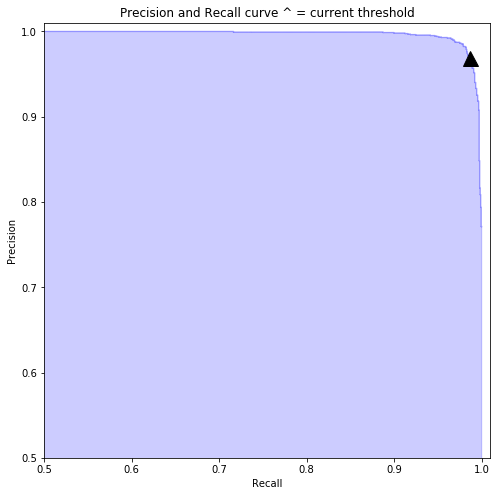

In [41]:
# The best I could do with 1 FN was 0.17, but re-execute to watch the confusion matrix change.
precision_recall_threshold(0.5)

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=5, label=label, color="r")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=5)
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='center')

0.9999682011499258


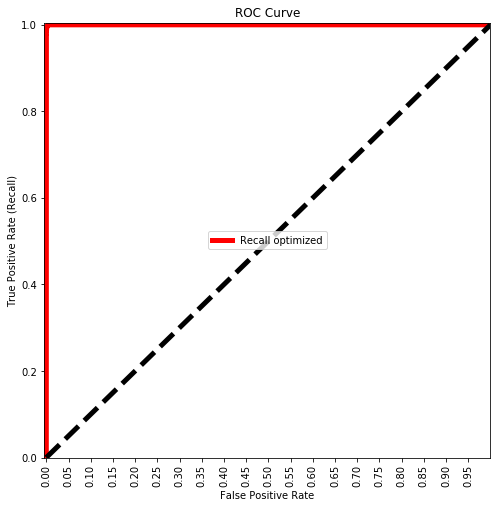

In [44]:
fpr, tpr, auc_thresholds = roc_curve(ytest, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'Recall optimized')

### (Not used) Oversampling of minority class with SMOTEEN
- Taking too long to run

In [25]:
# # Combination of over- and under-sampling with SMOTE-ENN
# smote_enn = SMOTEENN(sampling_strategy='minority', random_state=42, n_jobs=-1)
# X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(Xtr_sc, ytrain)

# unique, counts = np.unique(y_resampled_smoteenn, return_counts=True)
# print(np.asarray((unique, counts)).T)

[[0.00000e+00 4.39105e+05]
 [1.00000e+00 4.50365e+05]]


In [26]:
# joblib.dump(smote_enn, "smoteen_{}.pkl".format("qtr1"))

['smoteen_qtr1.pkl']

In [ ]:
# #  Unhash when needed
# #  Load the model from the file 
# smote_enn = joblib.load('smoteen_qtr1.pkl')  

# #  Unhash when needed
# #  Use the loaded model to make predictions 
# X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(Xtr_sc, ytrain)

In [ ]:
# #  fitting after Combination of over- and under-sampling with SMOTE-ENN
# #  Run with rest of gridsearchCV
# n_jobs_no = -3   # n_jobs as to set to "None" for xgboost to work

# scorers_dict = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     "f1_score": make_scorer(f1_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }


# gs_run(X_resampled_smoteenn, Xtest, y_resampled_smoteenn, ytest, n_jobs_no, scorers_dict, refit_score='recall_score', 
#        csv_name="comb_smoteenn_Gradboost_2")


In [ ]:
# # Run with XGB_GPU

# scorers_dict = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     "f1_score": make_scorer(f1_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

# gs_XGB_GPU_run(X_resampled_smoteenn, Xtest, y_resampled_smoteenn, ytest, scorers_dict, refit_score='recall_score', 
#                csv_name="smoteenn_XGBGPU_full_dask", n_jobs_no=None)

Fitting XGBoost_gpu
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.0, gamma=0.0, lambda=0.0, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic, predictor=gpu_predictor, subsample=0.5, tree_method=gpu_hist, verbosity=1 


In [14]:
# Create test samples for deployment
loan_test_dep = loan_full_clean_dum.sample(frac=0.05, random_state=759)
loan_test_2_dep = loan_full_clean_dum.sample(frac=0.05, random_state=93)
loan_test_3_dep = loan_full_clean_dum.sample(frac=0.05, random_state=86)

In [15]:
loan_test_2_dep.to_csv('./loan_dep_{}.csv'.format(2), index=False)
loan_test_3_dep.to_csv('./loan_dep_{}.csv'.format(3), index=False)

In [51]:
X_test_dep = loan_test_dep.drop(columns=["acc_now_delinq"])
y_test_dep = loan_test_dep["acc_now_delinq"]

#Scale Training & Test set
#ss = StandardScaler()
#Scaling for all features
X_test_dep_sc = ss.transform(X_test_dep)

### Results
<a id="Results"></a>

- Prediction on test dataset
- Best results were obtained after rebalancing minority class with SMOTE and rebalancing majority class with random under sampling
- XGBoost with hyperparameter tuning output the highest recall score with reasonable f1 score

In [52]:
pred_xgb_dep=xgb.predict(X_test_dep_sc)
print('Test Accuracy:', round((xgb.score(X_test_dep_sc, y_test_dep)*100),6),'%')
print(classification_report(y_test_dep, pred_xgb_dep))
cm_xgb_dep = cm_df(pred_xgb_dep, y_test_dep)
display(cm_xgb_dep)

Test Accuracy: 98.543689 %
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    112618
         1.0       0.85      0.99      0.92       412

    accuracy                           1.00    113030
   macro avg       0.93      0.99      0.96    113030
weighted avg       1.00      1.00      1.00    113030



,No Default,Default
pred No Default,112549,6
predicted Default,69,406


In [54]:
loan_test_dep.to_csv('./loan_dep_{}.csv'.format(1), index=False)

In [55]:
pred_xgb_dep

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
loan_qtr_1.to_csv('./loan_qtr_{}.csv'.format(1), index=False)

In [ ]:
#   Function for deployment
def model_predict(csv_path, ss=ss, xgb=xgb):
    loan_test_csv = csv_path
    with open(loan_test_csv, mode="r", encoding="utf8") as loan_test_dep:
        loan_test_dep = pd.read_csv(loan_test_dep)

    X = loan_test_dep.drop(columns=["acc_now_delinq"])
    ytest = loan_test_dep["acc_now_delinq"]

    # Scaling for all features
    Xts_sc = ss.transform(X)

    pred_xgb = xgb.predict(Xts_sc)

    print('Test Accuracy:', round((xgb.score(Xts_sc, ytest) * 100), 6), '%')
    print(classification_report(ytest, pred_xgb))
    cm_xgb_dep = cm_df(pred_xgb, ytest)
    print(cm_xgb_dep)
    return pred_xgb